# 네거티브 샘플링을 이용한 Word2Vec 구현(Skip-Gram with Negative Sampling, SGNS)

네거티브 샘플링은 Word2Vec이 학습 과정에서 전체 단어 집합이 아니라 일부 단어 집합에만 집중할 수 있도록 하는 방법.<br>
주변 단어는 긍정, 랜덤 샘플링 된 단어는 부정으로 취급

# 20뉴스그룹 데이터 전처리하기

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
# 하나의 샘플에 최소 단어 2개는 되어야 해서 전처리
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=("headers", "footers", "quotes"))
documents = dataset.data
print("총 샘플 수:", len(documents))

총 샘플 수: 11314


In [3]:
news_df = pd.DataFrame({"document": documents})

# 특수 문자 제거
news_df["clean_doc"] = news_df["document"].str.replace("[^a-zA-Z]", " ", regex=True)

# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df["clean_doc"] = news_df["clean_doc"].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))

# 전체 단어데 대한 소문자 변환
news_df["clean_doc"] = news_df["clean_doc"].apply(lambda x: x.lower())

In [4]:
# Null 값 존재 유무 확인
news_df.isnull().values.any()

False

In [15]:
# 빈 값 유무 확인
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [16]:
news_df.dropna(inplace=True)
print("총 샘플 수:", len(news_df))

총 샘플 수: 10995


In [17]:
# 불용어 제거 with NLTK
nltk.download('stopwords')

stop_words = stopwords.words('english')
tokenized_doc = news_df["clean_doc"].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# 단어가 1개 이하인 경우 중심 단어, 주변 단어가 존재하지 않으므로 불가.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
print(drop_train)

[44, 260, 353, 1651, 1839, 2321, 2336, 2371, 2862, 2963, 3290, 3387, 3395, 3396, 3421, 3563, 3591, 3713, 3874, 3897, 4180, 4524, 4587, 4617, 4947, 4970, 5129, 5525, 6015, 6227, 6652, 6723, 6883, 7080, 7956, 8000, 8156, 8212, 8283, 8588, 8867, 8903, 9045, 9555, 9696, 10439, 10447, 10564, 10707, 10730, 10750, 10838, 10896, 10908, 10967]


In [19]:
import numpy as np

# Convert tokenized_doc to a NumPy array with dtype=object to handle varying lengths
tokenized_doc_np = np.array(tokenized_doc, dtype=object)

# Now, np.delete should work as expected
tokenized_doc = np.delete(tokenized_doc_np, drop_train, axis=0)

In [20]:
# 단어 집합 생성, 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [21]:
# 단어 집합 크기 확인
vocab_size = len(word2idx) + 1
print("단어 집합의 크기:", vocab_size)

단어 집합의 크기: 64277


# 네거티브 샘플링을 통한 데이터셋 구성하기

전처리가 수행되는지 그 결과를 확인하기 위해서 꽤 시간이 소요되는 작업이므로 상위 10개의 뉴스그룹 샘플에 대해서만 수행

In [22]:
from tensorflow.keras.preprocessing.sequence import skipgrams

# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [23]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0],
          idx2word[pairs[i][1]], pairs[i][1],
          labels[i]))

(described (984), occured (4294)) -> 1
(europeans (4520), report (581)) -> 1
(israeli (442), silence (5384)) -> 0
(ruin (9470), israeli (442)) -> 1
(statement (474), mutated (17605)) -> 0


In [24]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2220
2220


In [25]:
# 모든 뉴스그룹 샘플에 skipgram 수행
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

# Skip-Gram with Negative Sampling(SGNS) 구현하기

In [26]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [27]:
# 임베딩 벡터 차원 100

embedding_dim = 100

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1,), dtype="int32")
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩테이블
c_inputs = Input(shape=(1,), dtype="int32")
context_embedding = Embedding(vocab_size, embedding_dim)(c_inputs)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 100)         │      6,427,700 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 100)         │      6,427,700 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 1, 1)           │              0 │ embedding[0][0],       │
│                           │                        │                │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1)              │              0 │ dot[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1)              │              0 │ reshape[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,855,400 (49.04 MB)

 Trainable params: 12,855,400 (49.04 MB)

 Non-trainable params: 0 (0.00 B)

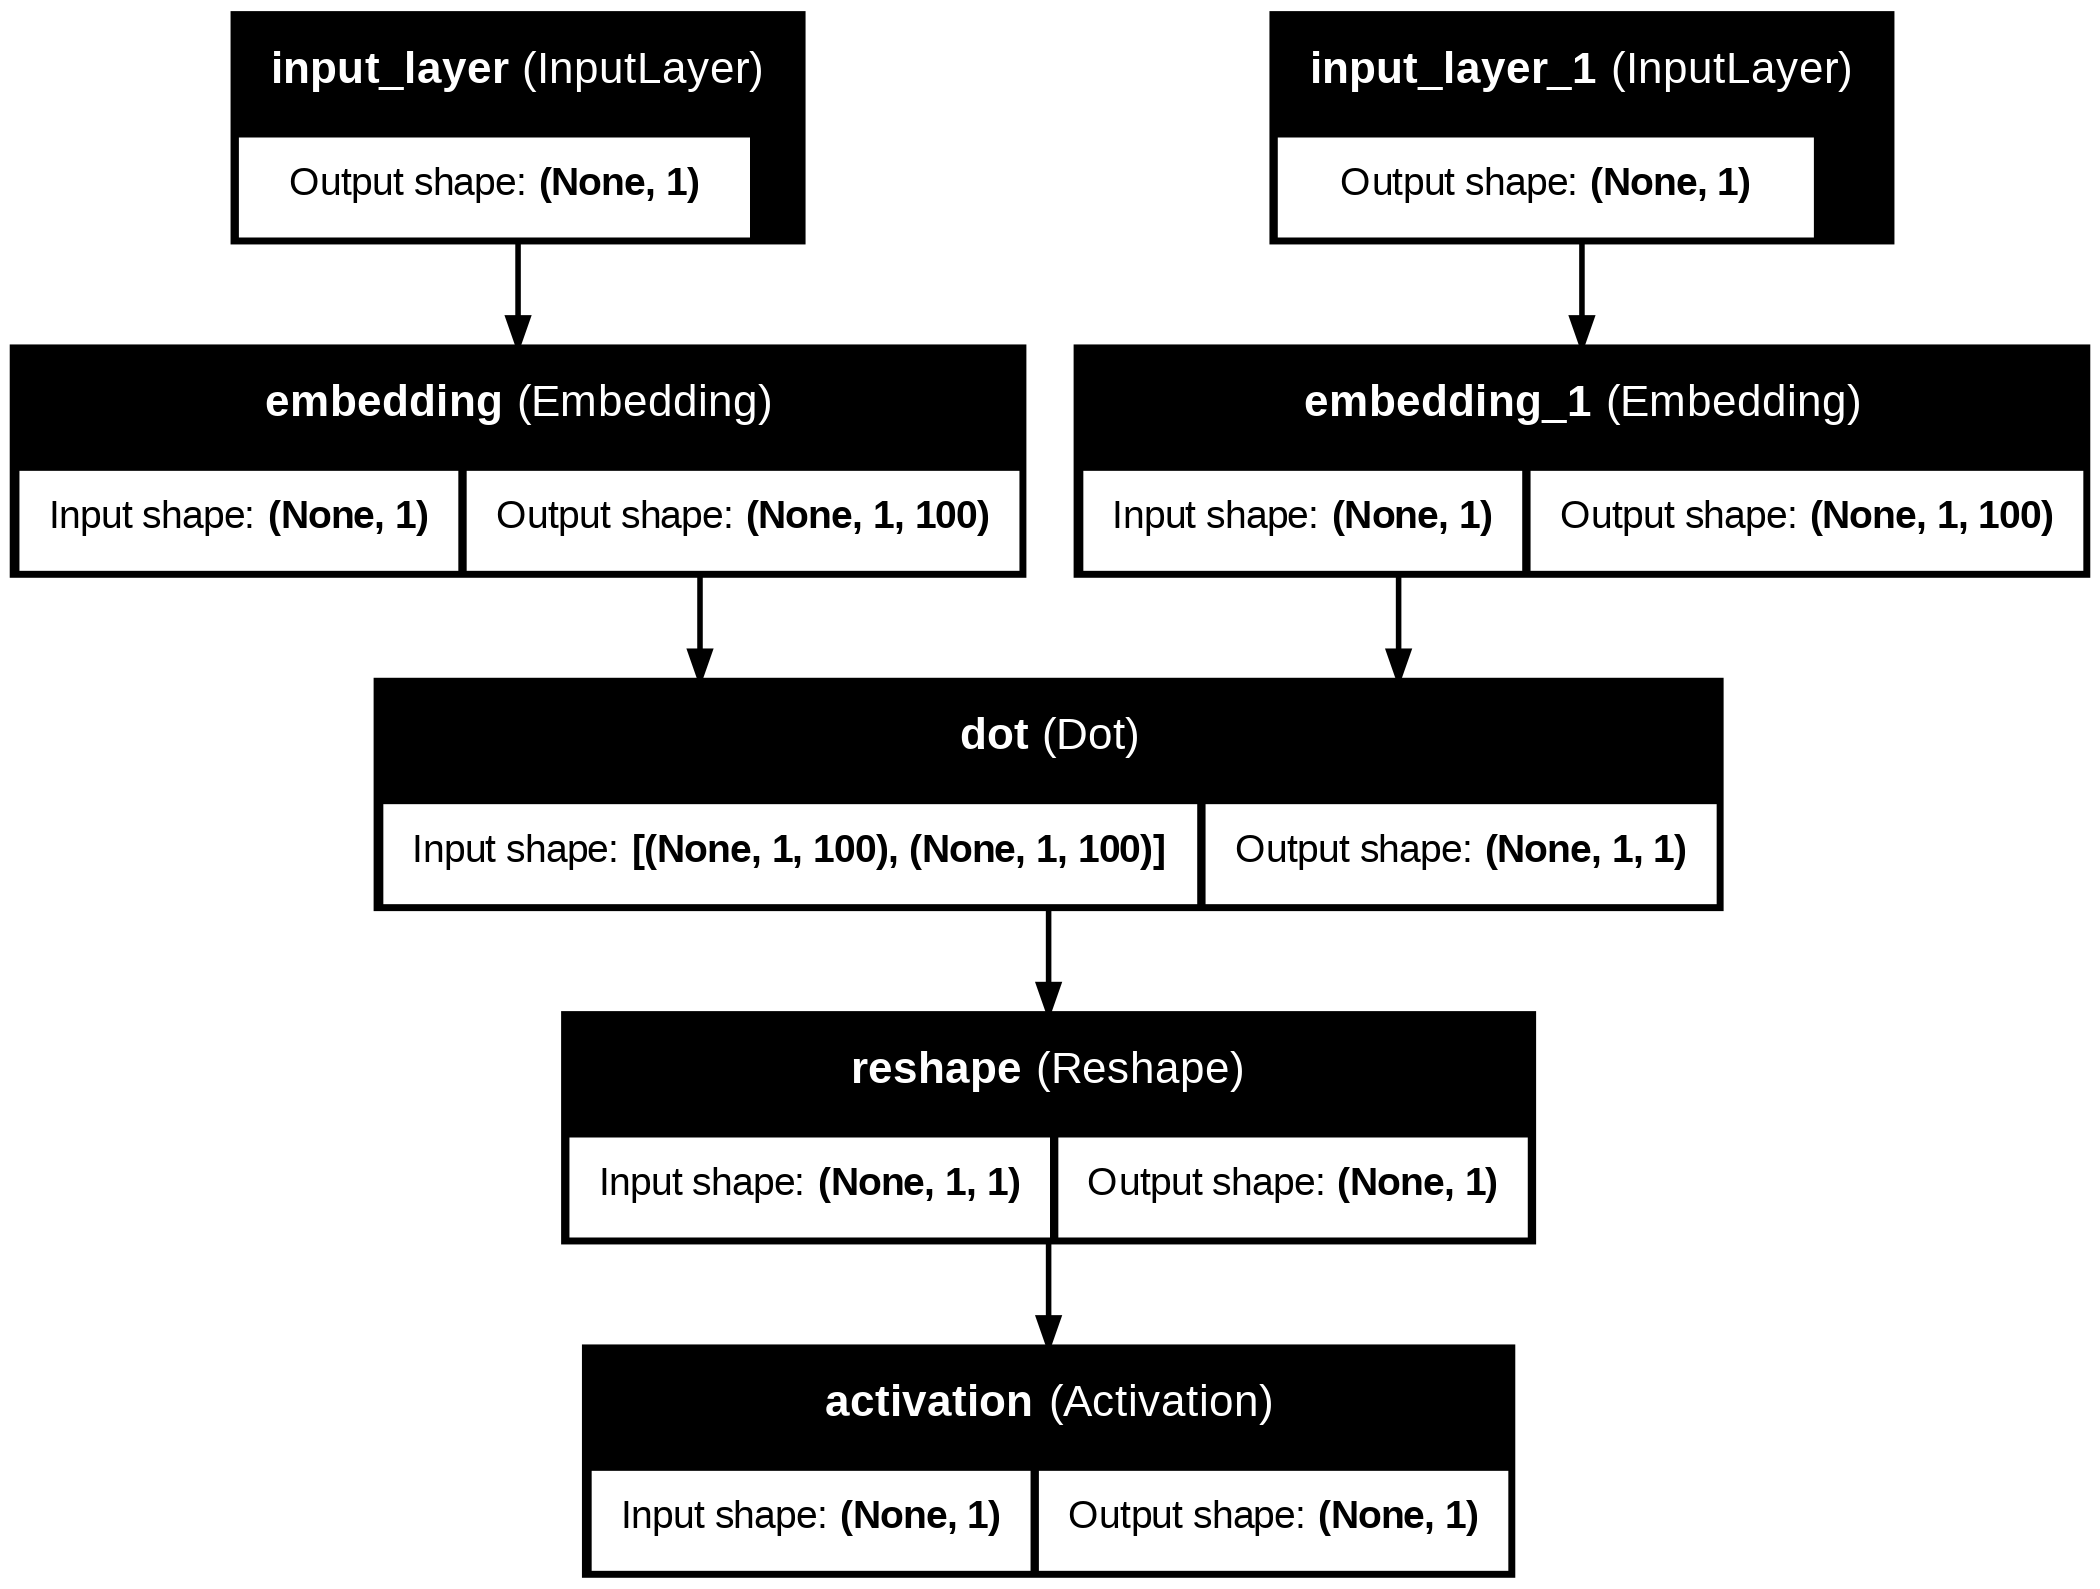

In [28]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation("sigmoid")(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam")
plot_model(model, to_file="model3.png", show_shapes=True, show_layer_names=True, rankdir="TB")

In [29]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype="int32")
        second_elem = np.array(list(zip(*elem[0]))[1], dtype="int32")
        labels = np.array(elem[1], dtype="int32")
        X = [first_elem, second_elem]
        y = labels
        loss += model.train_on_batch(X, y)
    print('Epoch:', epoch, "Loss:", loss)

Epoch: 1 Loss: 5387.241025388241
Epoch: 2 Loss: 4615.363303333521
Epoch: 3 Loss: 4471.807475030422
Epoch: 4 Loss: 4389.756281167269
Epoch: 5 Loss: 4315.183680891991


결과 확인하기

In [30]:
# 학습된 임베딩 벡터들을 vector.txt에 저장

import gensim

f = open("vectors.txt", "w")
f.write("{} {}\n".format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, " ".join(map(str, list(vectors[i, :])))))
f.close()

# 모델 로드
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

NameError: name 'embed_size' is not defined

In [ ]:
w2v.most_similar(positive=["soldiers"])
w2v.most_similar(positive=["doctor"])
w2v.most_similar(positive=["police"])
w2v.most_similar(positive=["knife"])